# Exercise Lesson 3, CNN 27.03.22

#### Group 6: 
Fatıma Rabia Yapıcıoglu (2049536), Giulia Bellentani (2027590), Asal Rangraziasi(2046832), Pu Yin (2005501)

GROUP WORK DIVISION:

Giulia Bellentani: Writing a general pseudocode scheme and then coding for question 2.

Fatima Rabia Yapicioglu: Modularizing generate data, create model, and train function. Coding for question 3.

Asal Rangraziasi and Pu Yin: Writing a pseudocode for question 3, regularization part. Checking functionalities, reassuring the functions work.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

%run plot.py

ERROR:root:File `'plot.py'` not found.


### Function for the random step
$DX$ is the standard deviation, $bias$ is the constant average of the step

In [2]:
# random seed for reproducibility
np.random.seed(12345)

# function for the random step, using lambda construction
# int() for cleaner look and for mimiking a detector with finite resolution
jump = lambda drift, stdev: int(np.random.normal(drift,stdev))

for i in range(10):
    print(jump(5,50))

-5
28
-20
-22
103
74
9
19
43
67


In [3]:
def Show_data(x,L,s="data"):
    plt.plot(np.arange(L),x[0])
    plt.plot(np.arange(L,2*L),x[1])
    plt.plot(np.arange(2*L,3*L),x[2])
    plt.title(s)
    plt.xlabel("time")
    plt.show()

### Function for the added pattern
to add to part of a time series, over $z$ bins, with amplitude $a$

In [4]:
def pattern(i,z,a):
    return int(a*np.sin((np.pi*i)/z))

## Data generation

[0, -5, 23, 3, -19, 84, 158, 167, 186, 229, 296, 351, 292, 310, 326, 398, 447, 352, 339, 427, 411, 390, 418, 585, 539, 516, 527, 547, 578, 583, 655, 625, 589, 476, 388, 350, 383, 325, 335, 287, 308, 196, 192, 120, 77, 17, 36, 59, 27, 48, 120, 128, 145, 149, 204, 275, 235, 163, 169, 211] 0
[183, 231, 235, 242, 280, 327, 285, 288, 307, 400, 449, 468, 575, 634, 655, 661, 561, 431, 270, 110, 126, 133, 81, 126, 152, 207, 303, 259, 306, 305, 355, 369, 482, 482, 587, 593, 637, 647, 615, 649, 661, 588, 565, 568, 527, 508, 511, 570, 624, 600, 684, 663, 690, 741, 668, 622, 607, 623, 619, 657] 1
[580, 623, 678, 663, 597, 579, 558, 521, 610, 643, 496, 417, 360, 369, 247, 190, 258, 256, 359, 489, 648, 783, 751, 706, 825, 746, 794, 774, 749, 796, 798, 793, 831, 835, 777, 810, 841, 801, 790, 777, 894, 865, 828, 836, 837, 826, 839, 855, 854, 851, 785, 799, 883, 811, 830, 807, 807, 804, 789, 732] 2
data:  10000


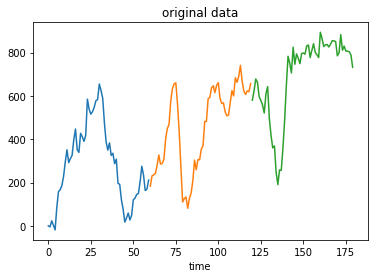

In [5]:
np.random.seed(12345)

def generate_data(N=10000, bias=5, DX=50, L=60, Z=12, A=500, show_res=True):
        y = [0] * N
        x = [[0] * L for i in range(N)]
        for i in range(N):
            if i>0:
                x[i][0] = x[i-1][-1] + jump(bias,DX)
            
            for j in range(1,L):
                x[i][j] = x[i][j-1] + jump(bias,DX)
                
            y[i] = i%3 
            ##y[i] = random.randint(0,2)
            if y[i]>0:
                j0 = np.random.randint(0,L-1-Z)
                ###print(i,j0,j1)
                sign = 3-2*y[i]
                for j in range(Z):
                    x[i][j0+j] += sign*pattern(j,Z,A)

        if show_res == True: 
            for i in range(min(3,N)):
                print(x[i],y[i])
        
        N,L = len(x), len(x[0])
        categ = y
        n_class = 3    #y.argmax()-y.argmin()+1

        if show_res == True:
            print('data: ',N)

        y = np.zeros((N,n_class))
        
        for i in range(N):
            y[i][categ[i]] = 1 
        return x, y, L, N
    
x, y, L, N = generate_data()

Show_data(x,L,"original data")

## Data analysis

#### Removing averages and rescaling input:

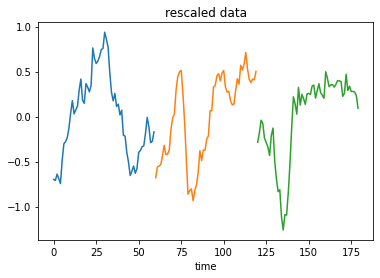

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [6]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
#remove average value of each sample from its values
def rescale_data(x, y, n_class, show_res=True):

        x = np.array(x)
        x = x.reshape((10000, 60))

        xm = x.mean(axis=1)
        for i in range(N):
            x[i] = x[i]-xm[i]

        #
        #  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
        #
        #rescale (crude version, variance should be used)
        x = x/400
            
        if show_res == True:
            Show_data(x,L,"rescaled data")

        perc_train=0.8
        N_train = int(perc_train*N)
        x_train = x[:N_train]
        y_train = y[:N_train]
        x_val = x[N_train:]
        y_val = y[N_train:]
        N_val = len(x_val)
        if show_res == True:
            print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

        #x_train=x_train.astype("float32")
        #y_train=y_train.astype("float32")
        #x_val=x_val.astype("float32")
        #y_val=y_val.astype("float32")

        # Keras wants an additional dimension with a 1 at the end
        x_train = x_train.reshape(x_train.shape[0], L, 1)
        x_val =  x_val.reshape(x_val.shape[0], L, 1)
        input_shape = (L, 1)

        return x_train, y_train, x_val,y_val, input_shape

x_train, y_train, x_val, y_val, input_shape = rescale_data(x,y,3)

#### Default model creation and training:

In [7]:
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

from keras import regularizers, initializers

reg = regularizers.l2(0.02)
ini = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
NCONV = 1
NF = 5

def create_model(reg, ini, NCONV, NF, input_shape, n_class=3):

    model = Sequential()

    if NCONV==1:
        model.add(Conv1D(filters=NF, kernel_size=11, kernel_initializer=ini, kernel_regularizer= reg, activation='relu', input_shape=input_shape))
        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters=5, kernel_size=7, activation='relu'))
        model.add(Flatten())
        model.add(Dense(12,activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(n_class,activation='softmax'))

    return model

model = create_model(reg, ini, NCONV, NF, input_shape,3 )

In [8]:
model.layers

In [9]:
 print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 5)             60        
                                                                 
 average_pooling1d (AverageP  (None, 10, 5)            0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 5)              180       
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 12)                252       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                        

In [10]:
opt = tf.keras.optimizers.Adam()
# SGD with nesterov should be used
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

In [11]:
BATCH_SIZE= 250
EPOCHS = 100

fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data =(x_val,y_val), verbose=2, shuffle=True)


Epoch 1/100
32/32 - 1s - loss: 1.0994 - accuracy: 0.3476 - val_loss: 1.0950 - val_accuracy: 0.3830 - 1s/epoch - 37ms/step
Epoch 2/100
32/32 - 0s - loss: 1.0873 - accuracy: 0.4024 - val_loss: 1.0733 - val_accuracy: 0.4200 - 201ms/epoch - 6ms/step
Epoch 3/100
32/32 - 0s - loss: 1.0493 - accuracy: 0.4814 - val_loss: 1.0207 - val_accuracy: 0.5370 - 201ms/epoch - 6ms/step
Epoch 4/100
32/32 - 0s - loss: 0.9808 - accuracy: 0.5720 - val_loss: 0.9318 - val_accuracy: 0.6560 - 203ms/epoch - 6ms/step
Epoch 5/100
32/32 - 0s - loss: 0.8992 - accuracy: 0.6314 - val_loss: 0.8299 - val_accuracy: 0.7090 - 201ms/epoch - 6ms/step
Epoch 6/100
32/32 - 0s - loss: 0.7951 - accuracy: 0.6956 - val_loss: 0.7234 - val_accuracy: 0.7595 - 235ms/epoch - 7ms/step
Epoch 7/100
32/32 - 0s - loss: 0.7002 - accuracy: 0.7446 - val_loss: 0.6171 - val_accuracy: 0.8055 - 203ms/epoch - 6ms/step
Epoch 8/100
32/32 - 0s - loss: 0.6080 - accuracy: 0.7819 - val_loss: 0.5211 - val_accuracy: 0.8445 - 240ms/epoch - 7ms/step
Epoch 9/10

#### Two methods that will be useful later on:

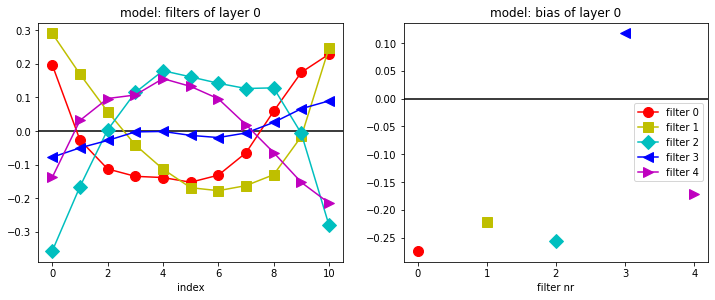

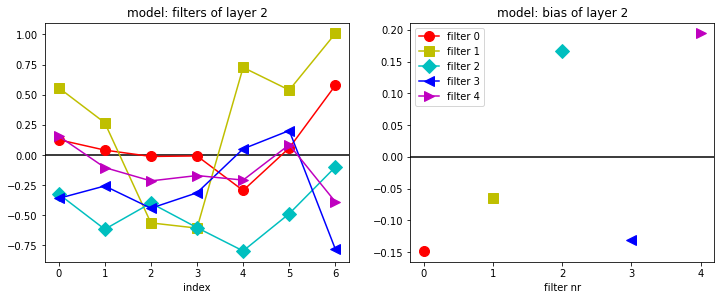

In [12]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

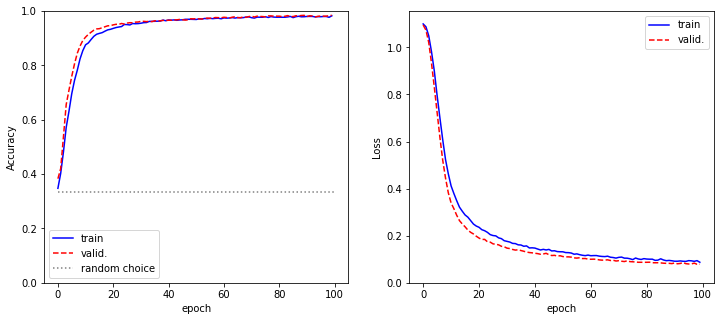

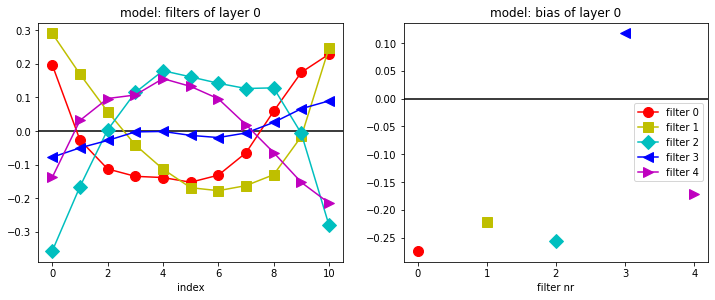

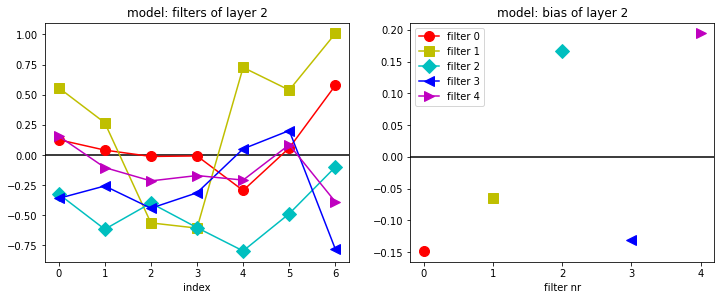

In [13]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

## Changing the signal-to-noise ratio
#### Performance of the CNN varying the amplitude A of the patterns while keeping DX fixed

For each value of A, we perform the training for 100 epochs and then we we select the last epoch value of validation loss and of validation accuracy. We are aware that this method does not directly check for the eventual presence of overfitting in some of the models, but we decided our priority in this part of the exercise was to pick the loss and accuracy value at the same number of epochs for each A value.

In [14]:
A_array = np.array([1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 80, 60, 40, 30, 20, 10], dtype=int)
losses_array = np.zeros(len(A_array))
accuracies_array = np.zeros(len(A_array))

for i in range(0,len(A_array)):

    x_A, y_A, L_A, N = generate_data(A=A_array[i], show_res=False)
    x_train_A, y_train_A, x_val_A, y_val_A, input_shape_A = rescale_data(x_A, y_A, 3, show_res=False)
    fit_A = model.fit(x_train_A, y_train_A, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val_A, y_val_A), verbose=2, shuffle=True)
    losses_array[i] = fit_A.history['val_loss'][-1]
    accuracies_array[i] = fit_A.history['val_accuracy'][-1]


Epoch 1/100
32/32 - 0s - loss: 0.0360 - accuracy: 0.9967 - val_loss: 0.0215 - val_accuracy: 1.0000 - 267ms/epoch - 8ms/step
Epoch 2/100
32/32 - 0s - loss: 0.0283 - accuracy: 0.9984 - val_loss: 0.0198 - val_accuracy: 1.0000 - 212ms/epoch - 7ms/step
Epoch 3/100
32/32 - 0s - loss: 0.0274 - accuracy: 0.9985 - val_loss: 0.0189 - val_accuracy: 1.0000 - 204ms/epoch - 6ms/step
Epoch 4/100
32/32 - 0s - loss: 0.0260 - accuracy: 0.9989 - val_loss: 0.0181 - val_accuracy: 1.0000 - 201ms/epoch - 6ms/step
Epoch 5/100
32/32 - 0s - loss: 0.0256 - accuracy: 0.9984 - val_loss: 0.0174 - val_accuracy: 1.0000 - 200ms/epoch - 6ms/step
Epoch 6/100
32/32 - 0s - loss: 0.0254 - accuracy: 0.9979 - val_loss: 0.0167 - val_accuracy: 1.0000 - 239ms/epoch - 7ms/step
Epoch 7/100
32/32 - 0s - loss: 0.0238 - accuracy: 0.9979 - val_loss: 0.0161 - val_accuracy: 1.0000 - 237ms/epoch - 7ms/step
Epoch 8/100
32/32 - 0s - loss: 0.0221 - accuracy: 0.9984 - val_loss: 0.0156 - val_accuracy: 1.0000 - 209ms/epoch - 7ms/step
Epoch 9/

We expect that, decreasing the value of A, at some point the validation losses and accuracies will be no longer satisfactory, as gradually the signal becomes undistinguishable from the noise. This hypothesis is confirmed by the dataframe showed below:
- for A equal to 400, results start to become worse
- for values of A equal to 100 and lower, results substantially reach a plateau: thus, this is is probably the value of A after which the signal is completly undistinguishable from the noise

In [15]:
losses_accuracies_df = (pd.DataFrame({"Losses" : losses_array, "Accuracies" : accuracies_array}, index=A_array)).T
display(losses_accuracies_df)

,1000,900,800,700,600,500,400,300,200,100,80,60,40,30,20,10
Losses,0.003282,0.002088,0.001839,0.007274,0.01476,0.052682,0.145502,0.480571,0.886344,1.089545,1.092987,1.100004,1.09969,1.098757,1.098613,1.098613
Accuracies,1.000000,1.000000,1.000000,0.998500,0.99750,0.987000,0.955500,0.824000,0.605500,0.390000,0.374500,0.342000,0.33600,0.333000,0.333000,0.333000


In [16]:
losses_array_min = np.min(losses_array)
losses_array_min_A = A_array[np.argmin(losses_array)]
accuracies_array_min = np.min(losses_array)
accuracies_array_min_A = A_array[np.argmin(accuracies_array)]

losses_array_max = np.max(losses_array)
losses_array_max_A = A_array[np.argmax(losses_array)]
accuracies_array_max = np.max(losses_array)
accuracies_array_max_A = A_array[np.argmax(accuracies_array)]


print('After a "100 epochs training" for each considered A value, the final minima and maxima are: ')
print("Losses array minimum: " + str(losses_array_min) + " (for A equal to " + str(losses_array_min_A) + ")")
print("Accuracies array minimum: " + str(accuracies_array_min) + " (for A equal to " + str(losses_array_min_A) + ")")
print("Losses array maximum: " + str(losses_array_max) + " (for A equal to " + str(losses_array_max_A) + ")")
print("The accuracies maximum: " + str(accuracies_array_max) + " (for A equal to " + str(losses_array_max_A) + ")")

After a "100 epochs training" for each considered A value, the final minima and maxima are: 
Losses array minimum: 0.0018389761680737138 (for A equal to 800)
Accuracies array minimum: 0.0018389761680737138 (for A equal to 800)
Losses array maximum: 1.100003957748413 (for A equal to 60)
The accuracies maximum: 1.100003957748413 (for A equal to 60)


### Regularization optimization:
#### Performance of the CNN varying the parameter lambda

We wanted to check if regularization may improve the performances of the CNN by varying the parameter lambda (as usual in magnitude: 0, 10^-5, 10^-4, 10^-3, etc.) of the L1 (Lasso) or of the L2 (Ridge) regularization functions. The distinction between Ridge and Lasso functions is that Lasso tends to bring coefficients towards zero, while Ridge never does. We wrote the code for both regularization functions, then we plotted all the accuracy and loss curves for the different rates of lambda on the same figure for comparison purposes.

#### Are performances of the CNN  optimized at some intermediate value of lambda?

The best lambda rate for the L1 model resulted as 0.001, so the performance of the CNN is optimized at 0.001, with a training accuracy of 98.60%, a training loss of 0.08%, a validation accuracy of 97.54%, and a validation loss of 0.06%. 

The best lambda rate for the model resulted as 0.00001, so the performance of the CNN is optimized at 0.00001, with a training accuracy of 97.98%, a training loss of 0.08%, a validation accuracy of 97.69%, and a validation loss of 0.08%.

####  Is there any improvement in the visualization and understanding of the weights in the filters? 

In a classic Neural Network, every connection between neurons has its weight. In a fully connected network, each neuron will be associated with many different weights. The peculiarity of CNNs is that convolutional layers have a fixed number of weights governed by the choice of filter size and the number of filters. Each filter has a separate weight in each position of its shape. For instance, if we use 3x3x3 filters, we will have 54 weights, not counting bias. The filter weights must be updated in back-propagation, since this is how CNN learns to recognize the features of the input. CNN learns more and more complex features of the input image as it gets deeper into the network. These are all learned by adjusting the filter weights through back-propagation.

Furthermore, learning rate is a hyper-parameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Model weights are updated to reduce the error estimated by our loss function. With a large learning rate, the algorithm learns fast, but it may also cause the algorithm to oscillate around or even jump over the minima. A high learning rate equals large weight updates, which might cause the weights to overflow. On the contrary, with a small learning rate, updates to the weights are small, which will guide the optimizer gradually towards the minima. However, the optimizer may take too long to converge or get stuck in places like a plateau or an undesirable local minima. 

In [17]:
def change_regularized_model(reg, model):

    BATCH_SIZE2 = 250
    EPOCHS2 = 100

    model=keras.models.clone_model(model)
    model.layers[0].kernel_regularizers = reg
    model.layers[2].kernel_regularizers = reg
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE2, epochs=EPOCHS2, validation_data =(x_val,y_val), verbose=0, shuffle=True)
    
    return fit, model


In [18]:
# Feeding different rates to the L2 regularizer

rates = [0,0.01,0.001,0.0001,0.00001]
fits_l2 = []
models_l2 = []

for i in range(0,len(rates)):
    reg = regularizers.l2(rates[i])
    fit, model = change_regularized_model(reg, model)
    fits_l2.append(fit)
    models_l2.append(model)
    print('The model with L2 regularizer lambda rate ', rates[i], 'train_acc',fit.history['accuracy'][-1], 'train_loss',fit.history['loss'][-1], 'val_accuracy', fit.history['val_accuracy'][-1], 'val_loss',fit.history['val_loss'][-1] )

The model with L2 regularizer lambda rate  0 train_acc 0.9848750233650208 train_loss 0.06972027570009232 val_accuracy 0.9810000061988831 val_loss 0.07257354259490967
The model with L2 regularizer lambda rate  0.01 train_acc 0.9832500219345093 train_loss 0.07446618378162384 val_accuracy 0.9769999980926514 val_loss 0.08212826400995255
The model with L2 regularizer lambda rate  0.001 train_acc 0.9768750071525574 train_loss 0.09052719175815582 val_accuracy 0.9750000238418579 val_loss 0.10196299105882645
The model with L2 regularizer lambda rate  0.0001 train_acc 0.9757500290870667 train_loss 0.09482379257678986 val_accuracy 0.9725000262260437 val_loss 0.09525085985660553
The model with L2 regularizer lambda rate  1e-05 train_acc 0.984000027179718 train_loss 0.0729624554514885 val_accuracy 0.9794999957084656 val_loss 0.08215504139661789


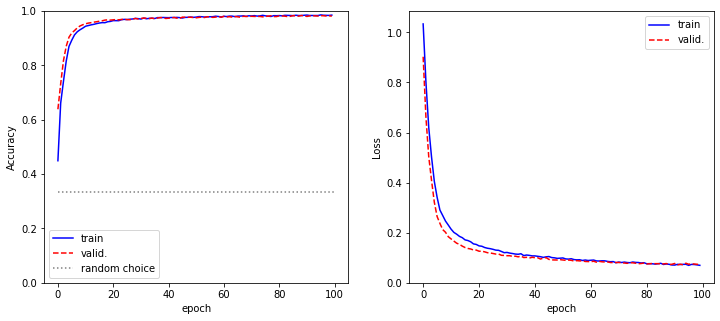

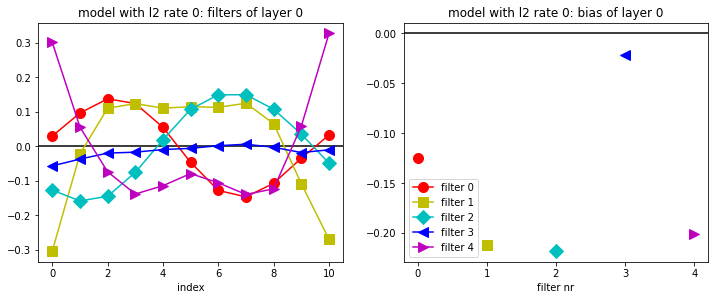

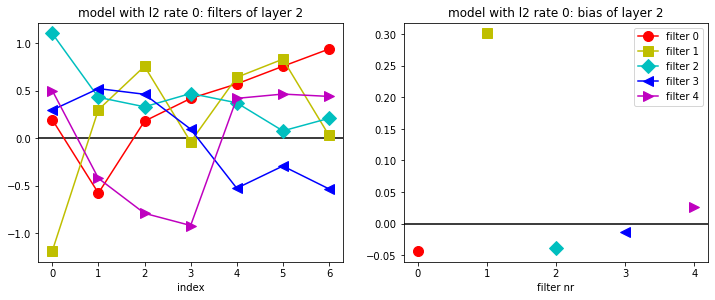

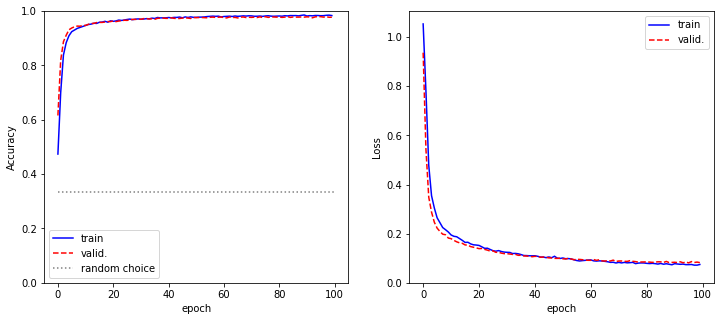

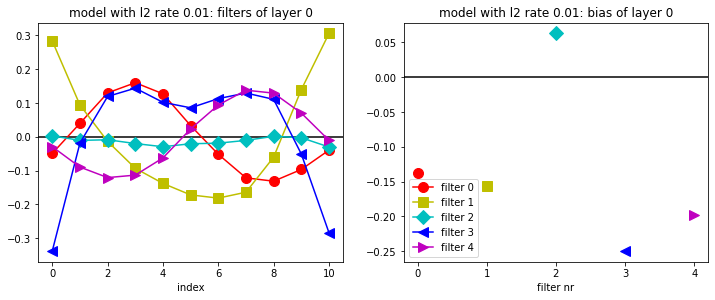

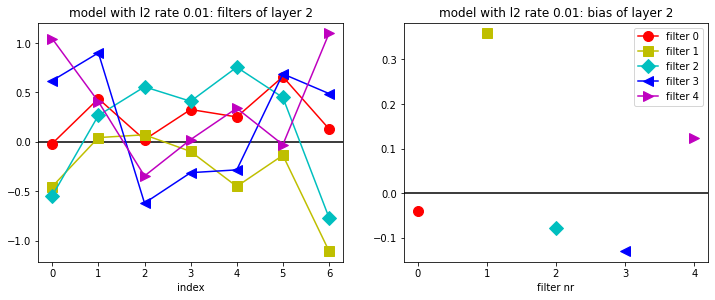

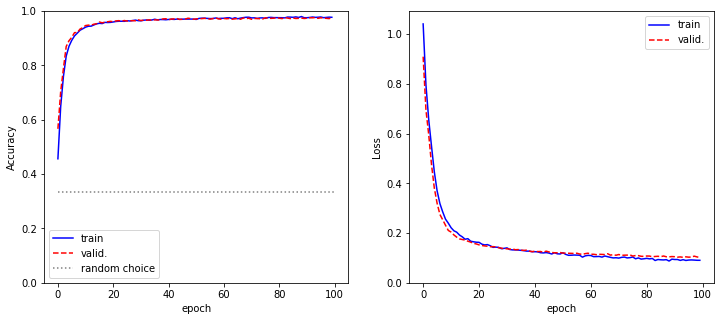

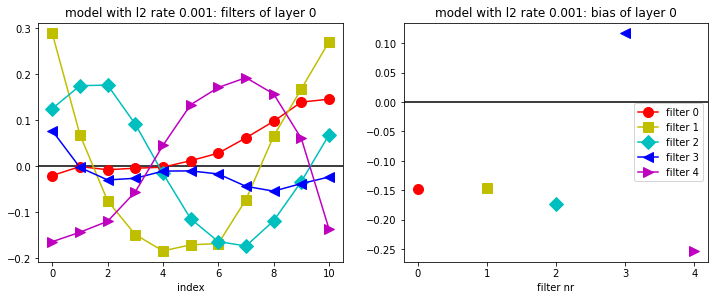

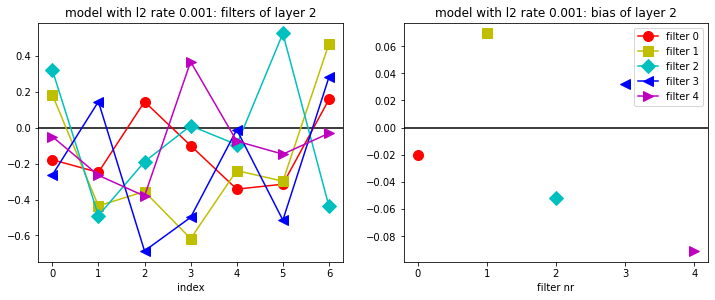

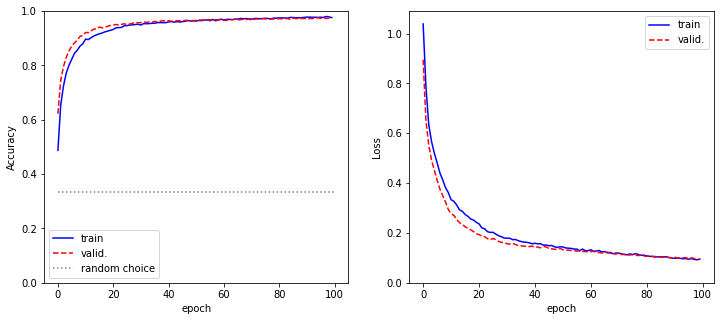

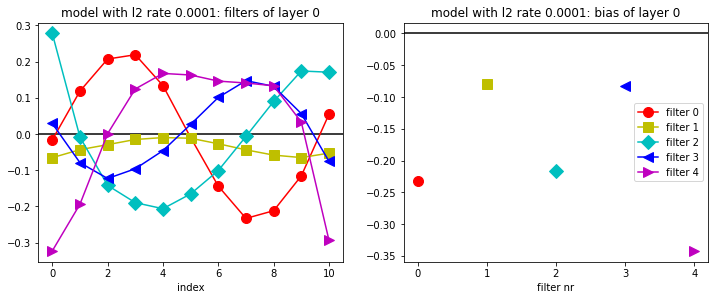

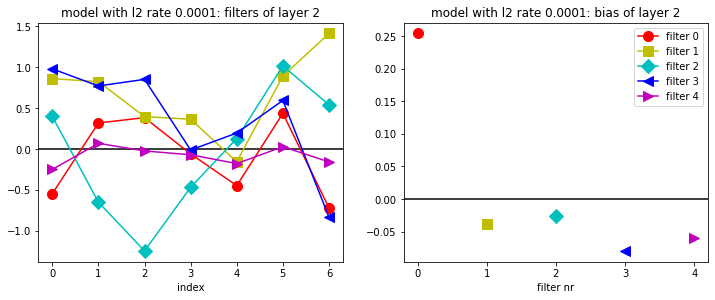

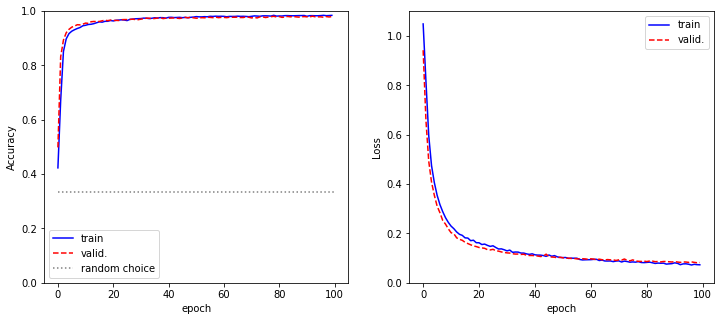

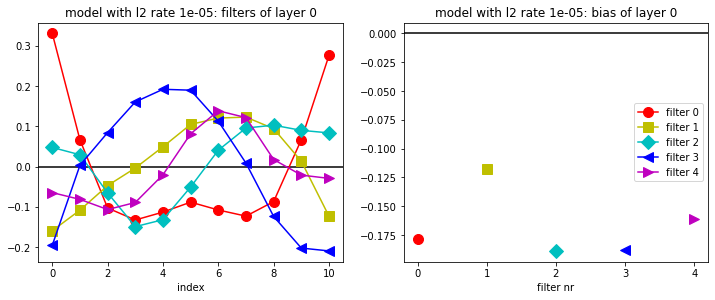

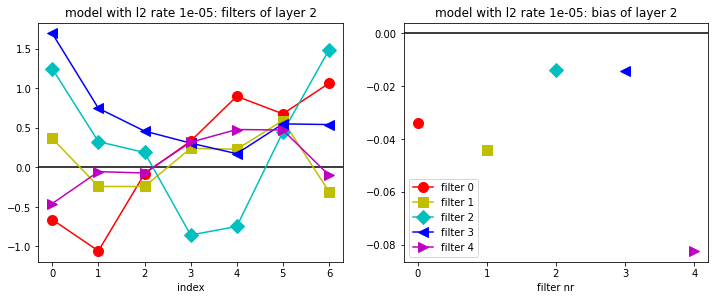

In [19]:
#Visualizing the accuracy aand loss for the l2 regularizer
for i in range(0,len(rates)):
    Show_history(fits_l2[i])
    Show_weights(models_l2[i],0,label="model with l2 rate "+str(rates[i]))
    Show_weights(models_l2[i],2,label="model with l2 rate "+str(rates[i]))

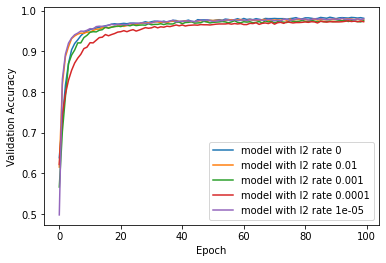

In [20]:
import matplotlib.pyplot as plt

for i in range(0,len(rates)):
    plt.plot(fits_l2[i].history['val_accuracy'],label="model with l2 rate "+str(rates[i]))
    plt.xlabel('Epoch')
    plt.ylabel("Validation Accuracy")
    plt.legend()

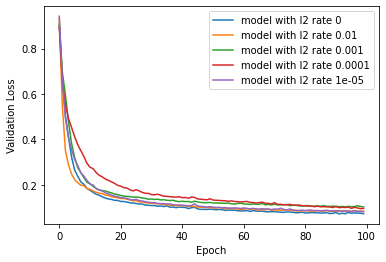

In [21]:
import matplotlib.pyplot as plt

for i in range(0,len(rates)):
    plt.plot(fits_l2[i].history['val_loss'],label="model with l2 rate "+str(rates[i]))
    plt.xlabel('Epoch')
    plt.ylabel("Validation Loss")
    plt.legend()

In [22]:
# Feeding different rates to the L1 regularizer
rates = [0,0.01,0.001,0.0001,0.00001]
fits_l1 = []
models_l1 = []

for i in range(0,len(rates)):
    reg = regularizers.l1(rates[i])
    fit, model = change_regularized_model(reg, model)
    fits_l1.append(fit)
    models_l1.append(model)
    print('The model with L1 regularizer lambda rate ', rates[i], 'train_acc',fit.history['accuracy'][-1], 'train_loss',fit.history['loss'][-1], 'val_accuracy', fit.history['val_accuracy'][-1], 'val_loss',fit.history['val_loss'][-1] )

The model with L1 regularizer lambda rate  0 train_acc 0.9661250114440918 train_loss 0.12663181126117706 val_accuracy 0.9649999737739563 val_loss 0.12659907341003418
The model with L1 regularizer lambda rate  0.01 train_acc 0.9816250205039978 train_loss 0.08258439600467682 val_accuracy 0.9794999957084656 val_loss 0.07630477845668793
The model with L1 regularizer lambda rate  0.001 train_acc 0.984749972820282 train_loss 0.07297007739543915 val_accuracy 0.9800000190734863 val_loss 0.0764339491724968
The model with L1 regularizer lambda rate  0.0001 train_acc 0.9837499856948853 train_loss 0.07172257453203201 val_accuracy 0.9815000295639038 val_loss 0.07592969387769699
The model with L1 regularizer lambda rate  1e-05 train_acc 0.984375 train_loss 0.06582744419574738 val_accuracy 0.9835000038146973 val_loss 0.07162249088287354


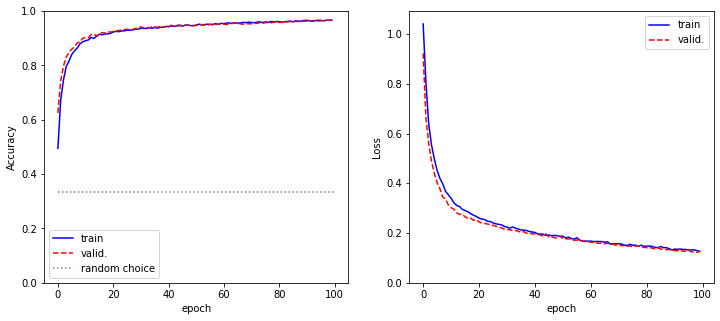

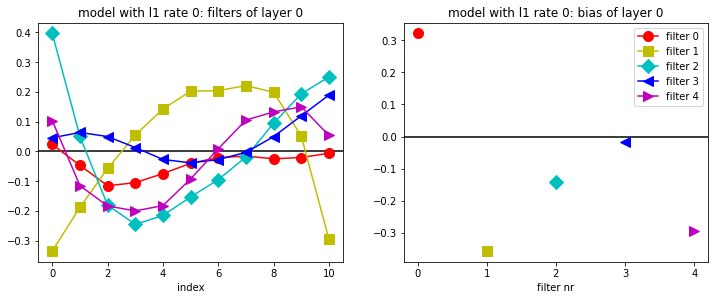

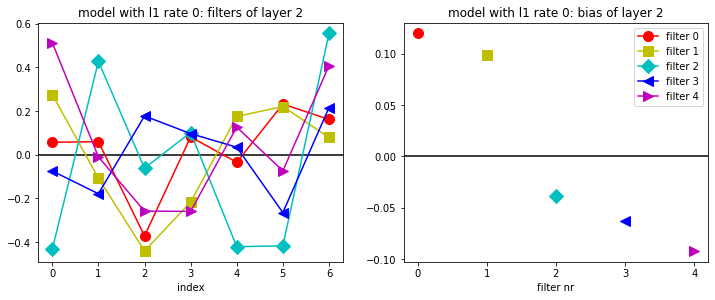

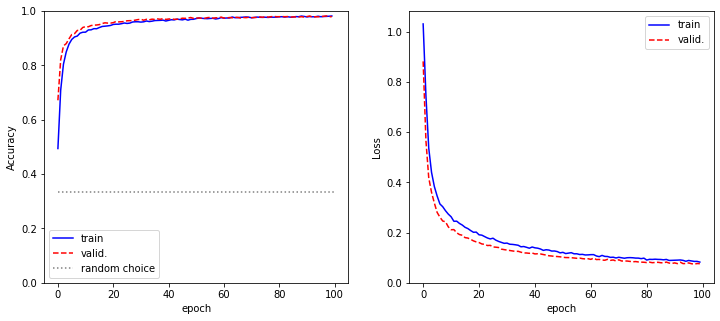

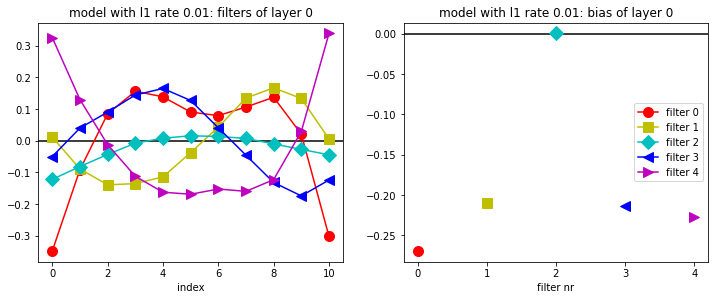

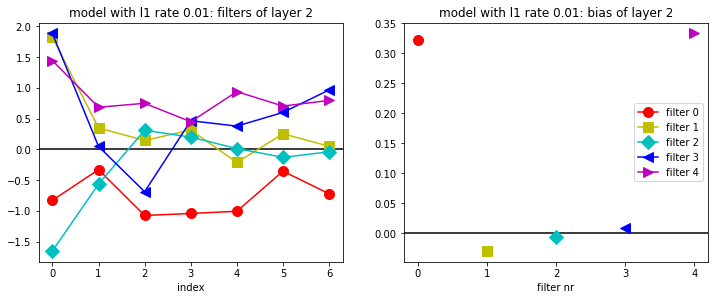

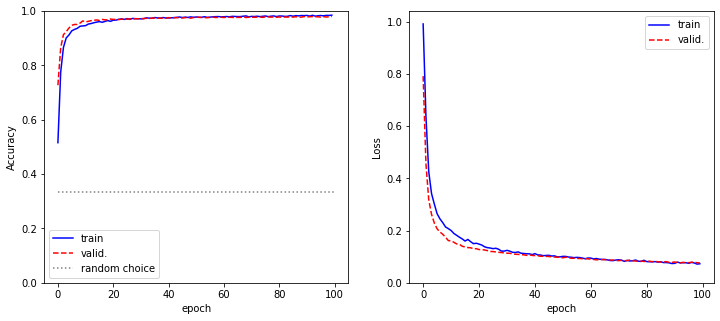

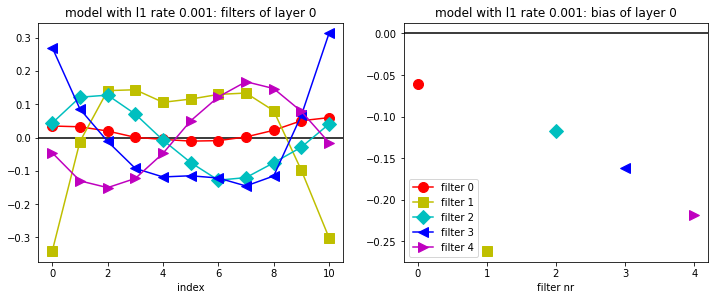

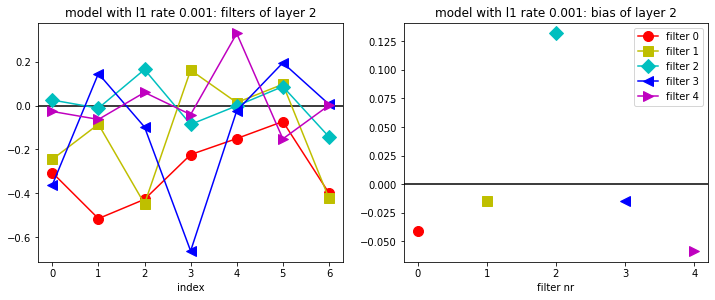

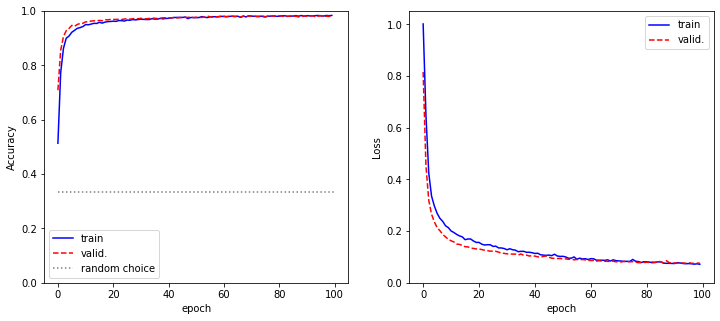

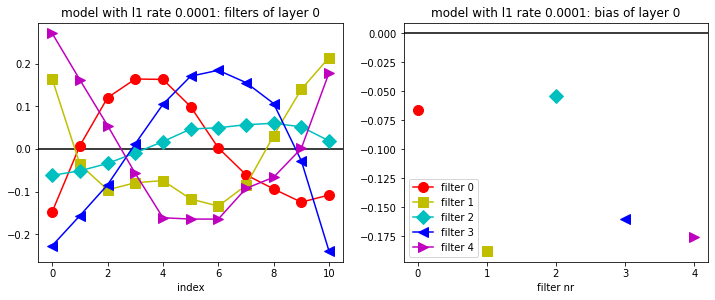

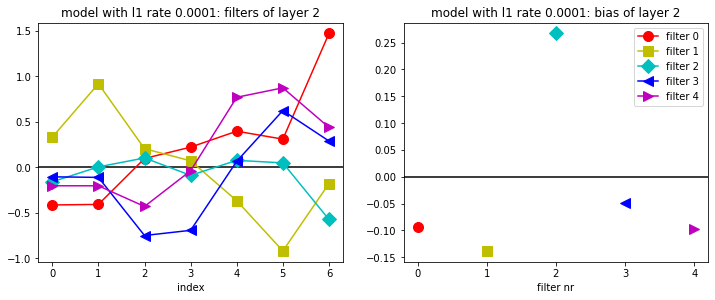

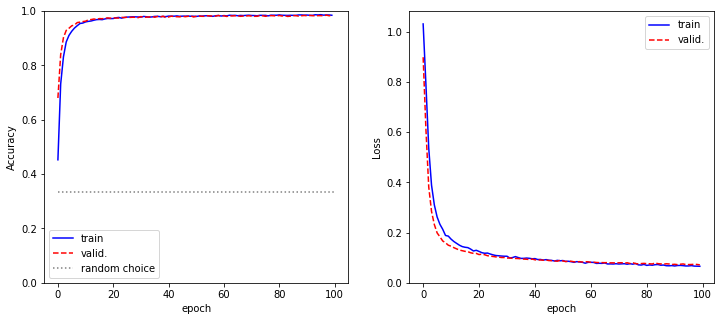

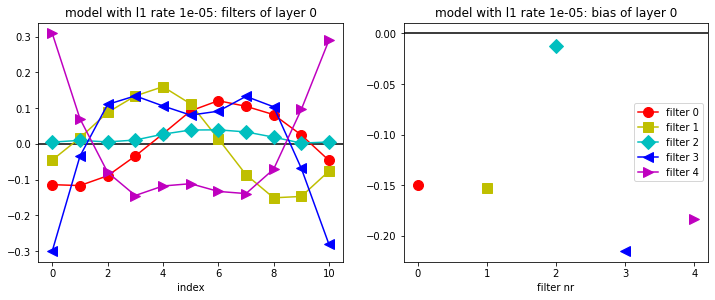

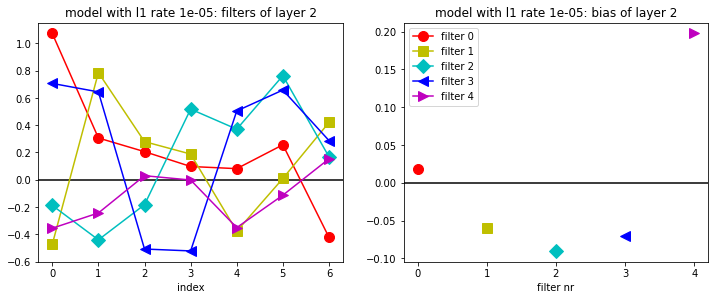

In [23]:
#Visualizing the accuracy and loss for the l2 regularizer
for i in range(0,len(rates)):
    Show_history(fits_l1[i])
    Show_weights(models_l1[i],0,label="model with l1 rate "+str(rates[i]))
    Show_weights(models_l1[i],2,label="model with l1 rate "+str(rates[i]))

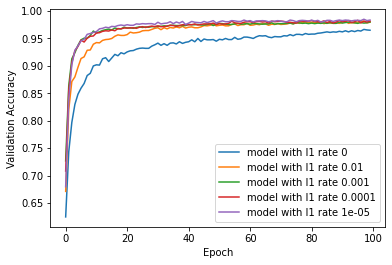

In [24]:
import matplotlib.pyplot as plt

for i in range(0,len(rates)):
    plt.plot(fits_l1[i].history['val_accuracy'],label="model with l1 rate "+str(rates[i]))
    plt.xlabel('Epoch')
    plt.ylabel("Validation Accuracy")
    plt.legend()

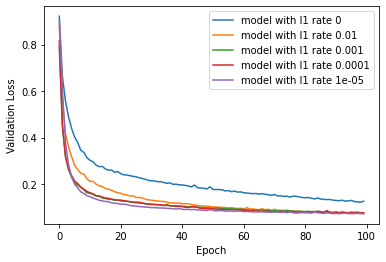

In [25]:
for i in range(0,len(rates)):
    plt.plot(fits_l1[i].history['val_loss'],label="model with l1 rate "+str(rates[i]))
    plt.xlabel('Epoch')
    plt.ylabel("Validation Loss")
    plt.legend()

In [26]:
l1_rates_ACCURACIES_ARRAY = np.zeros(len(rates))
l1_rates_LOSSES_ARRAY = np.zeros(len(rates))

for i in range (0,len(rates)):
    
    l1_rates_ACCURACIES_ARRAY[i]= fits_l1[i].history['val_accuracy'][-1]
    l1_rates_LOSSES_ARRAY[i]= fits_l1[i].history['val_loss'][-1]


l1_rates_ACCURACIES_ARRAY_max= np.max(l1_rates_ACCURACIES_ARRAY)
l1_rates_ACCURACIES_ARRAY_max_rate= rates[np.argmax( l1_rates_ACCURACIES_ARRAY)]
l1_rates_LOSSES_ARRAY_min= np.min(l1_rates_LOSSES_ARRAY)
l1_rates_LOSSES_ARRAY_min_rate= rates[np.argmin(l1_rates_LOSSES_ARRAY)]

l2_rates_ACCURACIES_ARRAY = np.zeros(len(rates))
l2_rates_LOSSES_ARRAY = np.zeros(len(rates))

for i in range (0,len(rates)):
    
    l2_rates_ACCURACIES_ARRAY[i]= fits_l2[i].history['val_accuracy'][-1]
    l2_rates_LOSSES_ARRAY[i]= fits_l2[i].history['val_loss'][-1]


l2_rates_ACCURACIES_ARRAY_max= np.max(l2_rates_ACCURACIES_ARRAY)
l2_rates_ACCURACIES_ARRAY_max_rate= rates[np.argmax(l2_rates_ACCURACIES_ARRAY)]
l2_rates_LOSSES_ARRAY_min= np.min(l2_rates_LOSSES_ARRAY)
l2_rates_LOSSES_ARRAY_min_rate= rates[np.argmin(l2_rates_LOSSES_ARRAY)]


print("for model with L1 regularizer:")
print(" maximum accuracy:  "+ str(l1_rates_ACCURACIES_ARRAY_max)+" with a rate of: "+ str(l1_rates_ACCURACIES_ARRAY_max_rate))
print(" minimum loss:  "+ str(l1_rates_LOSSES_ARRAY_min)+" with a rate of: "+ str(l1_rates_LOSSES_ARRAY_min_rate))

print("for model with L2 regularizer:")
print(" maximum accuracy:  "+ str( l2_rates_ACCURACIES_ARRAY_max)+" with a rate of: "+ str( l2_rates_ACCURACIES_ARRAY_max_rate))
print(" minimum loss:  "+ str(l2_rates_LOSSES_ARRAY_min)+" with a rate of: "+ str(l2_rates_LOSSES_ARRAY_min_rate))


for model with L1 regularizer:
 maximum accuracy:  0.9835000038146973 with a rate of: 1e-05
 minimum loss:  0.07162249088287354 with a rate of: 1e-05
for model with L2 regularizer:
 maximum accuracy:  0.9810000061988831 with a rate of: 0
 minimum loss:  0.07257354259490967 with a rate of: 0


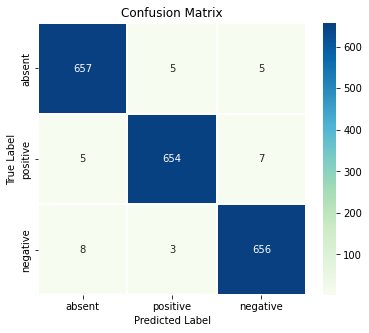

In [27]:
from scipy import stats
import seaborn 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)

#print(classification_report(max_y_val, max_y_pred_val))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0ade2068-1048-4781-a6cd-535a7bb8bb26' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>